In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import camb
from camb import model, initialpower

In [2]:
# load data
zs = np.loadtxt('/home/alex/axionNL_new/optimal_z_array.dat')
ratios_copy = np.loadtxt('nonlinear_ratios.dat')
pknl_array = np.loadtxt('nonlinear_pks.dat')
k_array = np.loadtxt('paramfiles/cosmos_transfer_out.dat')[:,0]

In [3]:
# interpolate pk
ratios_interp = RegularGridInterpolator((np.log10(k_array), zs), ratios_copy.T, method='linear', bounds_error=False,
    fill_value=1.0,)
pknl_interp = RegularGridInterpolator((np.log10(k_array), zs), np.log10(pknl_array).T, method='linear', bounds_error=False,
    fill_value=1.0,)

In [4]:
# Run camb prediction (high-ish accuracy)

#For calculating large-scale structure and lensing results yourself, get a power spectrum
#interpolation object. In this example we calculate the CMB lensing potential power
#spectrum using the Limber approximation, using PK=camb.get_matter_power_interpolator() function.
#calling PK(z, k) will then get power spectrum at any k and redshift z in range.

nz = 100 #number of steps to use for the radial/redshift integration
kmax=10  #kmax to use
#First set up parameters as usual
pars = camb.CAMBparams()

#pars.set_cosmology(H0=67.4, ombh2=0.02237, omch2=0.12)
#pars.InitPower.set_params(ns=0.9655, As=2.2e-9)

pars.set_cosmology(H0=67.4, ombh2=0.02237, omch2=0.12, mnu=0.06, num_massive_neutrinos = 1, nnu=3.044)
pars.InitPower.set_params(ns=0.9655, As=2.2e-9)

pars.set_matter_power(accurate_massive_neutrino_transfers=True,k_per_logint=10)
pars.set_accuracy(AccuracyBoost=1.2, );

pars.set_for_lmax(4000,lens_potential_accuracy=2,nonlinear='mead2016',lens_margin=1050)
pars.NonLinear = model.NonLinear_both
pars.NonLinearModel.set_params('mead2016',)# HMCode_A_baryon = 3.13, HMCode_eta_baryon = 0.603)

#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results= camb.get_background(pars)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs_camb=results.redshift_at_comoving_radial_distance(chis)
#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs_camb = zs_camb[1:-1]

#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs_camb[-1])

In [5]:
pkml = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_tot,var2=model.Transfer_tot, zmax=zs_camb[-1])

pkmnl = camb.get_matter_power_interpolator(pars, nonlinear='mead2016', 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_tot,var2=model.Transfer_tot, zmax=zs_camb[-1])

(0.0005, 100)

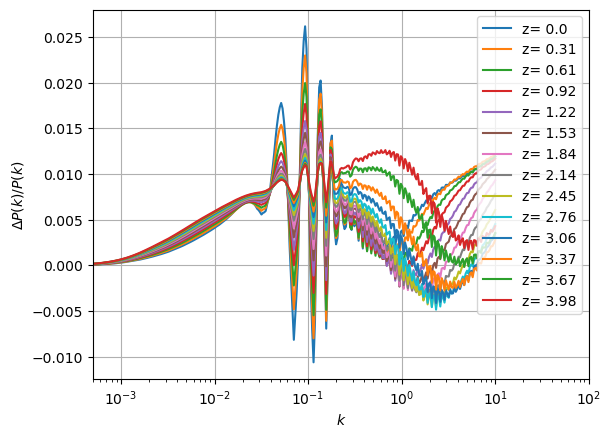

In [6]:
# Compare the nonlinear ratios
ks = np.logspace(-3.5, 1, 300)
for z in zs[zs<=4]:
    plt.semilogx(ks, ratios_interp((np.log10(ks/0.674), z))/(pkmnl.P(z, ks)/pkml.P(z, ks))-1, label="z= " +str(round(z, 2)))
#plt.loglog(ks, ratios_interp((ks/0.674, 0.5)))
#plt.ylim(-0.03, 0.03)
plt.ylabel("$\Delta P(k)/P(k)$")
plt.xlabel('$k$')
plt.legend()
plt.grid()
plt.xlim(5e-4, 100)

In [7]:
#Get lensing window function (flat universe)
win = ((chistar-chis)/(chis**2*chistar))**2
#Do integral over chi
ls = np.arange(2,4000+1, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs_camb, k, grid=False) *ratios_interp((np.log10(k/0.674), zs_camb)) *win/k**4)
cl_kappa*= (ls*(ls+1))**2

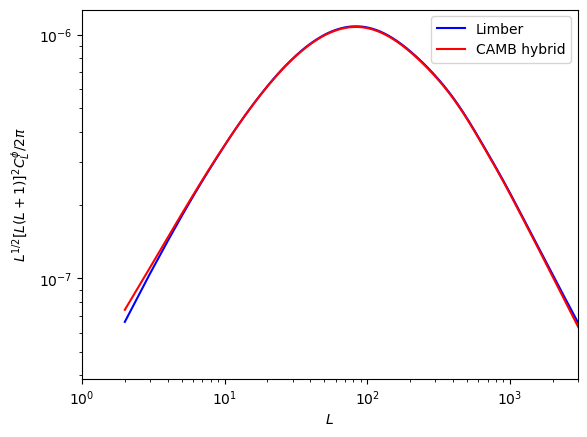

Text(0.5, 1.0, 'Updated Halo Model Lensing vs CAMB (high accuracy)')

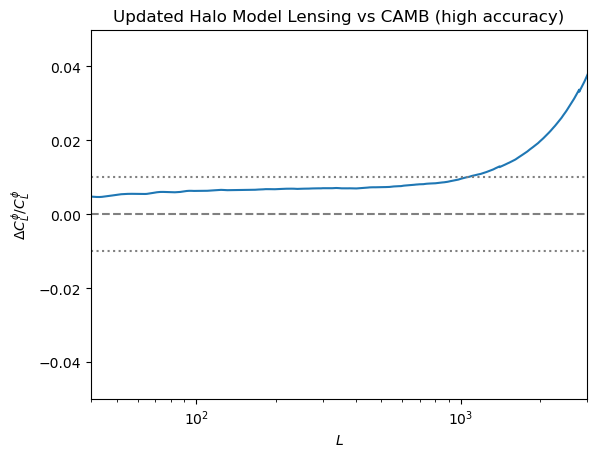

In [8]:
#Compare with CAMB's calculation:
#note that to get CAMB's internal calculation accurate at the 1% level at L~2000, 
#need lens_potential_accuracy=2. Increase to 4 for accurate match to the Limber calculation here

results = camb.get_results(pars)
cl_camb=results.get_lens_potential_cls(4000)[:,0]
#cl_camb[:,0] is phi x phi power spectrum (other columns are phi x T and phi x E)

#ls_camb, cl_camb = np.loadtxt('high_accuracy_camb_lensing.dat')

#Make plot. Expect difference at very low-L from inaccuracy in Limber approximation, and
#very high L from differences in kmax (lens_potential_accuracy is only 2, though good by eye here)
cl_limber= 4*cl_kappa/2/np.pi #convert kappa power to [l(l+1)]^2C_phi/2pi (what cl_camb is)
plt.loglog(ls,ls**.5*cl_limber, color='b')
plt.loglog(ls,ls**.5*cl_camb[2:], color='r')
plt.xlim([1,3000])
plt.legend(['Limber','CAMB hybrid'])
plt.ylabel('$L^{1/2}[L(L+1)]^2C_L^{\phi}/2\pi$')
plt.xlabel('$L$')
plt.show()

plt.semilogx(ls,cl_limber[:int(np.max(ls))-1]/cl_camb[2:]-1)
plt.xlim(40, 3000)
plt.ylim(-0.05, 0.05)
#plt.grid(ls=":")
plt.ylabel('$\Delta C^{\phi}_L/C^{\phi}_L$')
plt.xlabel('$L$')
plt.axhline(y=0.01, ls=':', c='grey')
plt.axhline(y=-0.01, ls=':', c='grey')
plt.axhline(y=0.0, ls='--', c='grey')
#plt.loglog(np.arange(2,cl_camb[:,0].size),cl_camb[2:,0], color='r')
plt.title('Updated Halo Model Lensing vs CAMB (high accuracy)')